In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch import nn

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act, **kwargs):
        super().__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            **kwargs,
            bias=True,
        )
        self.act = nn.LeakyReLU(0.2, inplace=True) if use_act else nn.Identity()

    def forward(self, x):
        return self.act(self.cnn(x))

In [3]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_c, scale_factor=2):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode="nearest")
        self.conv = nn.Conv2d(in_c, in_c, 3, 1, 1, bias=True)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.act(self.conv(self.upsample(x)))

In [4]:
class DenseResidualBlock(nn.Module):
    def __init__(self, in_channels, channels=32, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.blocks = nn.ModuleList()

        for i in range(5):
            self.blocks.append(
                ConvBlock(
                    in_channels + channels * i,
                    channels if i <= 3 else in_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    use_act=True if i <= 3 else False,
                )
            )

    def forward(self, x):
        new_inputs = x
        for block in self.blocks:
            out = block(new_inputs)
            new_inputs = torch.cat([new_inputs, out], dim=1)
        return self.residual_beta * out + x

In [5]:
class RRDB(nn.Module):
    def __init__(self, in_channels, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.rrdb = nn.Sequential(*[DenseResidualBlock(in_channels) for _ in range(3)])

    def forward(self, x):
        return self.rrdb(x) * self.residual_beta + x

In [6]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=23):
        super().__init__()
        self.initial = nn.Conv2d(
            in_channels,
            num_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
        )
        self.residuals = nn.Sequential(*[RRDB(num_channels) for _ in range(num_blocks)])
        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.upsamples = nn.Sequential(
            UpsampleBlock(num_channels), UpsampleBlock(num_channels),
        )
        self.final = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(num_channels, in_channels, 3, 1, 1, bias=True),
        )

    def forward(self, x):
        initial = self.initial(x)
        x = self.conv(self.residuals(initial)) + initial
        x = self.upsamples(x)
        return self.final(x)

In [7]:
generator = Generator(in_channels=3)

checkpoint_file = "model/gen.pth"

checkpoint = torch.load(checkpoint_file, map_location=torch.device("cpu"))
generator.load_state_dict(checkpoint["state_dict"])

generator.eval()

Generator(
  (initial): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (residuals): Sequential(
    (0): RRDB(
      (rrdb): Sequential(
        (0): DenseResidualBlock(
          (blocks): ModuleList(
            (0): ConvBlock(
              (cnn): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): LeakyReLU(negative_slope=0.2, inplace=True)
            )
            (1): ConvBlock(
              (cnn): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): LeakyReLU(negative_slope=0.2, inplace=True)
            )
            (2): ConvBlock(
              (cnn): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): LeakyReLU(negative_slope=0.2, inplace=True)
            )
            (3): ConvBlock(
              (cnn): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): LeakyReLU(negative_slope=0.2, inplace=True)
            )


In [8]:
transform_input = A.Compose(
        [
            A.Resize(width=64, height=64),
            A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
            ToTensorV2(),
        ]
    )

># User Input

In [9]:
user_input = "user_input/test_sample (4).png"

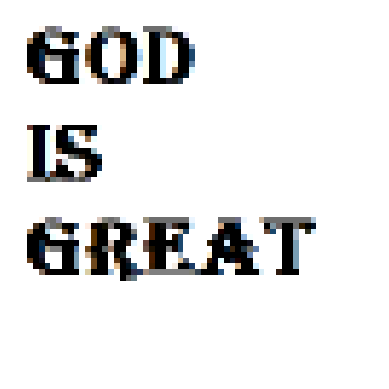

In [10]:
input_image = cv2.imread(user_input)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

plt.imshow(input_image)
plt.axis("off")
plt.show()

In [11]:
image = transform_input(image=input_image)["image"]

In [12]:
with torch.no_grad():
    generated_clear = generator(image.unsqueeze(0).to(torch.device("cpu")))
    mean = torch.tensor([0, 0, 0]).view(1, 3, 1, 1)
    std = torch.tensor([1, 1, 1]).view(1, 3, 1, 1)
    generated_clear = generated_clear * std + mean

In [13]:
generated_clear = generated_clear.squeeze(0)
generated_clear = generated_clear.permute(1,2,0).cpu().numpy()
generated_clear = np.clip(generated_clear, 0, 1)

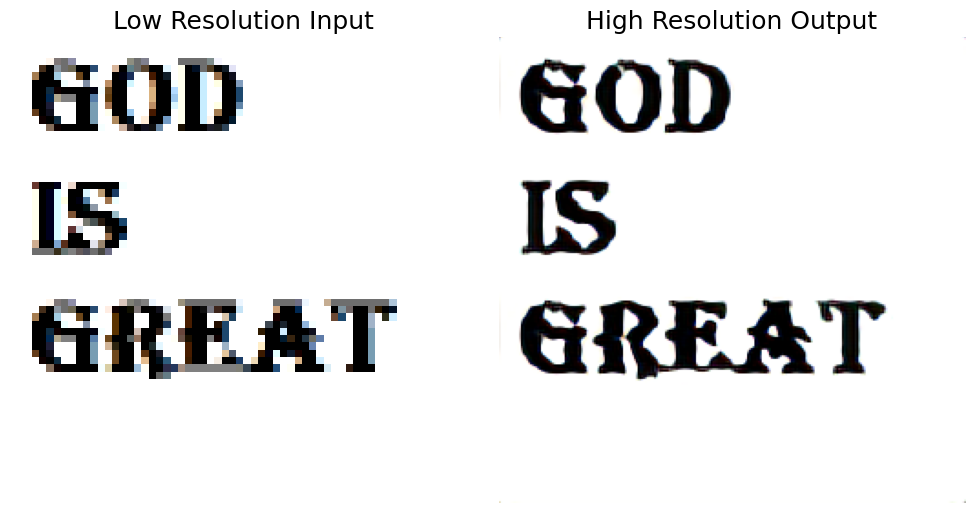

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
plt.rcParams['font.size'] = 15

ax[0].imshow(input_image)
ax[0].axis("off")
ax[0].set_title(label="Low Resolution Input")
ax[1].imshow(generated_clear)
ax[1].axis("off")
ax[1].set_title(label="High Resolution Output")

plt.tight_layout()
plt.show()

In [16]:
print(f"Shape of Input Image: {input_image.shape}")
print(f"Shape of Output Image: {generated_clear.shape}")

Shape of Input Image: (64, 64, 3)
Shape of Output Image: (256, 256, 3)


---